Source:

https://towardsdatascience.com/machine-learning-text-processing-1d5a2d638958

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
import nltk
from nltk.corpus import stopwords
import string
import re
import warnings
warnings.filterwarnings("ignore")
import os
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score,precision_score, balanced_accuracy_score,f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, jaccard_score
# from sklearn.metrics import plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB



from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

### Check out the Data


In [30]:
df= pd.read_csv('SPAM text message 20170820 - Data.csv')
df.head(5)
len(df)

5572

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Category    5572 non-null object
Message     5572 non-null object
dtypes: object(2)
memory usage: 43.6+ KB


### Exploratory Data Analysis



Let's use groupby to use describe by Category, this way we can begin to think about the features that separate ham and spam!


In [32]:
df.groupby('Category').describe()


Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

Let's make a new column to detect how long the text messages are

In [161]:
df['Length'] = df['Message'].apply(len)
df.head()

Category                                            Message  Length
0         0  Go until jurong point, crazy.. Available only ...     111
1         0                      Ok lar... Joking wif u oni...      29
2         1  Free entry in 2 a wkly comp to win FA Cup fina...     155
3         0  U dun say so early hor... U c already then say...      49
4         0  Nah I don't think he goes to usf, he lives aro...      61

Let's see the percentage of ham and spam in our dataset

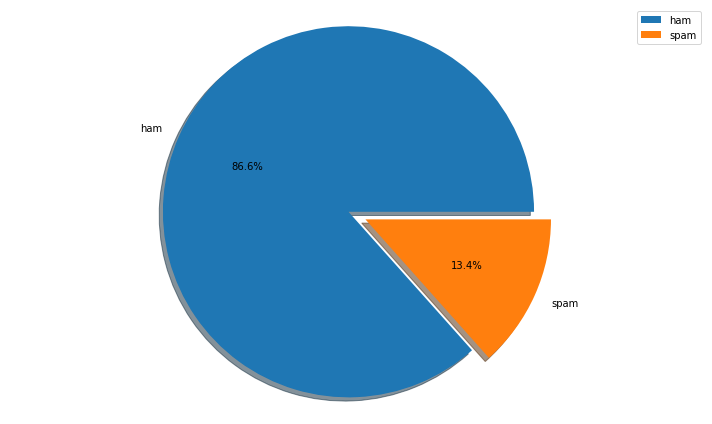

In [155]:
explode = (0.1,0)  
fig1, ax1 = plt.subplots(figsize=(10,6))
ax1.pie(df['Category'].value_counts(), explode=explode,labels=['ham','spam'], autopct='%1.1f%%',
        shadow=True)

# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.legend()
plt.show()

Text(0.5, 0, 'Length')

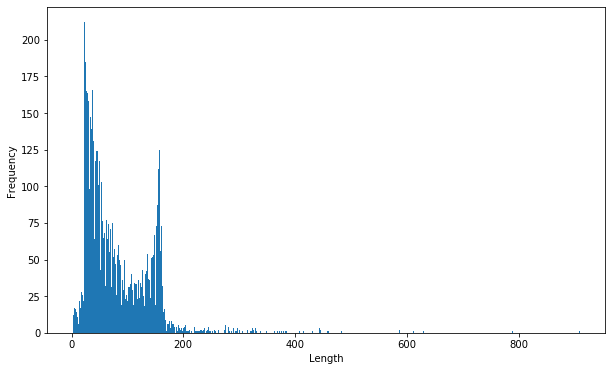

In [35]:
plt.figure(figsize=(10,6))
df['Length'].plot.hist(bins = 500)
plt.xlabel('Length')

One of the text has 910 characters, let's use masking to find this message:


In [162]:
df[df['Length'] == 910]['Message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

### WordCloud

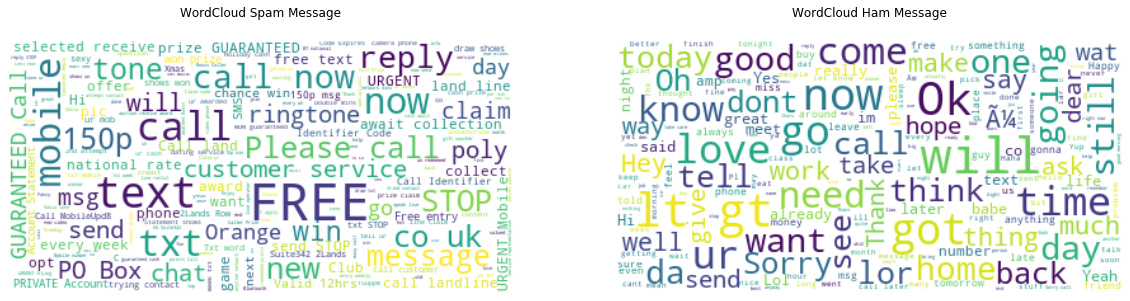

In [163]:
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

# Read the whole text.
textspam = open(path.join(d, 'dataspam.csv')).read()
textham= open(path.join(d, 'dataham.csv')).read()

# Generate a word cloud image

# Display the generated image:

# lower max_font_size
wordcloudspam = WordCloud(max_font_size=40, background_color="white").generate(textspam)
wordcloudham= WordCloud(max_font_size=40, background_color="white").generate(textham)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(wordcloudspam, interpolation="bilinear")
plt.title('WordCloud Spam Message')
plt.axis("off")

plt.subplot(122)
plt.imshow(wordcloudham, interpolation="bilinear")
plt.title('WordCloud Ham Message')
plt.axis("off")

plt.show()


### Text Cleaning

clean the text for the messages in dataset

============================

    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Handling lower/upper case
    4. Returns a list of the cleaned text


In [38]:
df["Category"] = df["Category"].map({'ham': 0,'spam':1})

In [39]:
df.head(5)

Category                                            Message  Length
0         0  Go until jurong point, crazy.. Available only ...     111
1         0                      Ok lar... Joking wif u oni...      29
2         1  Free entry in 2 a wkly comp to win FA Cup fina...     155
3         0  U dun say so early hor... U c already then say...      49
4         0  Nah I don't think he goes to usf, he lives aro...      61


## Feature Extraction

In [168]:
description_list = []
for article in df["Message"]:
    article = re.sub("[^a-zA-Z]"," ",article)
    article = article.lower()   # low case letter
    article = word_tokenize(article)
    lemma = WordNetLemmatizer()
    article = [ lemma.lemmatize(word) for word in article]
    article = " ".join(article)
    description_list.append(article) #we hide all word one section
    
    
# def text_replace(text):
#     '''some text cleaning method'''
#     text = text.lower()
#     text = re.sub('\[.*?\]', '', text)
#     text = re.sub('https?://\S+|www\.\S+', '', text)
#     text = re.sub('<.*?>+', '', text)
#     text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#     text = re.sub('\n', '', text)
#     text = re.sub('\w*\d\w*', '', text)
#     return text
# description_list

### Word Count Vectorizer

<img src="count_vect.png" width="800" height="400">

In [145]:
# max faetures= 100 supaya hanya memilih 100 kata teratas berdasarkan frekuensi kata antar corpus.
# stop_words: Since CountVectorizer just counts the occurrences of each word in its vocabulary, extremely common words like ‘the’, ‘and’, etc. 
count_vectorizer = CountVectorizer(max_features = 100, stop_words = "english")
sparce_matrix = count_vectorizer.fit_transform(description_list).toarray()
tokens = count_vectorizer.get_feature_names()

In [42]:
print(type(sparce_matrix))
sparce_matrix = pd.DataFrame(sparce_matrix, columns=tokens)
sparce_matrix.head()



<class 'numpy.ndarray'>


amp  ask  babe  care  cash  claim  com  come  contact  da  ...  wat  way  \
0    0    0     0     0     0      0    0     0        0   0  ...    1    0   
1    0    0     0     0     0      0    0     0        0   0  ...    0    0   
2    0    0     0     0     0      0    0     0        0   0  ...    0    0   
3    0    0     0     0     0      0    0     0        0   0  ...    0    0   
4    0    0     0     0     0      0    0     0        0   0  ...    0    0   

   week  win  won  work  www  yeah  year  yes  
0     0    0    0     0    0     0     0    0  
1     0    0    0     0    0     0     0    0  
2     0    1    0     0    0     0     0    0  
3     0    0    0     0    0     0     0    0  
4     0    0    0     0    0     0     0    0  

[5 rows x 100 columns]

In [43]:
vectorizer = TfidfVectorizer(max_features = 100)
tfidfmatrix = vectorizer.fit_transform(description_list)
cname = vectorizer.get_feature_names()
tfidfmatrix = pd.DataFrame(tfidfmatrix.toarray(),columns=cname)
tfidfmatrix.head()
# tfidfmatrix.describe()

about  all   am  and  any  are   at  back   be  but  ...   wa  want   we  \
0    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   0.0  0.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   0.0  0.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   0.0  0.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   0.0  0.0   
4    0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  ...  0.0   0.0  0.0   

   week  what  when  will  with  you  your  
0   0.0   0.0   0.0   0.0   0.0  0.0   0.0  
1   0.0   0.0   0.0   0.0   0.0  0.0   0.0  
2   0.0   0.0   0.0   0.0   0.0  0.0   0.0  
3   0.0   0.0   0.0   0.0   0.0  0.0   0.0  
4   0.0   0.0   0.0   0.0   0.0  0.0   0.0  

[5 rows x 100 columns]

In [44]:
tfidfmatrix.columns

Index(['about', 'all', 'am', 'and', 'any', 'are', 'at', 'back', 'be', 'but',
       'by', 'call', 'can', 'come', 'da', 'day', 'do', 'don', 'dont', 'for',
       'free', 'from', 'get', 'go', 'going', 'good', 'got', 'gt', 'ha', 'have',
       'he', 'her', 'hi', 'home', 'how', 'if', 'in', 'is', 'it', 'just',
       'know', 'later', 'like', 'll', 'lor', 'love', 'lt', 'me', 'mobile',
       'my', 'need', 'new', 'no', 'not', 'now', 'of', 'ok', 'on', 'one',
       'only', 'or', 'our', 'out', 'phone', 'please', 'pls', 'reply', 'see',
       'send', 'she', 'so', 'sorry', 'still', 'stop', 'take', 'tell', 'text',
       'that', 'the', 'then', 'there', 'they', 'think', 'this', 'time', 'to',
       'today', 'txt', 'up', 'ur', 'wa', 'want', 'we', 'week', 'what', 'when',
       'will', 'with', 'you', 'your'],
      dtype='object')

### Count_Vectorizer Train Test Split

In [45]:
y = df.iloc[:,0].values   
x = sparce_matrix
tfidfx = tfidfmatrix
x

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2,random_state=1115 )
print(len(x_train), len(x_test), len(x_train) + len(x_test))

4457 1115 5572


In [46]:
x_train.head(5)

amp  ask  babe  care  cash  claim  com  come  contact  da  ...  wat  \
2419    0    0     0     0     0      0    0     0        0   0  ...    0   
952     0    0     0     0     0      0    0     0        0   0  ...    0   
3312    0    0     0     0     0      0    0     0        0   0  ...    0   
1842    0    0     0     0     0      0    0     0        0   0  ...    0   
18      0    0     0     0     0      0    0     0        0   0  ...    0   

      way  week  win  won  work  www  yeah  year  yes  
2419    0     0    0    0     0    0     0     0    0  
952     0     0    0    0     0    0     0     0    0  
3312    0     0    0    0     1    0     0     0    0  
1842    0     0    0    0     0    0     0     0    0  
18      2     0    0    0     0    0     0     0    0  

[5 rows x 100 columns]

### TF IDF Train Test Split

In [47]:
tf_x_train, tf_x_test, tf_y_train, tf_y_test = train_test_split(tfidfmatrix ,y,
                                                                test_size = 0.2,
                                                                random_state = 1115)

In [48]:
tf_x_train.head(5)

about       all        am  and  any  are   at  back        be       but  \
2419    0.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  0.683204  0.000000   
952     0.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  0.000000  0.000000   
3312    0.0  0.277472  0.000000  0.0  0.0  0.0  0.0   0.0  0.000000  0.244712   
1842    0.0  0.000000  0.690558  0.0  0.0  0.0  0.0   0.0  0.000000  0.000000   
18      0.0  0.000000  0.000000  0.0  0.0  0.0  0.0   0.0  0.000000  0.000000   

      ...       wa  want   we  week  what  when  will  with  you      your  
2419  ...  0.00000   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.000000  
952   ...  0.00000   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.000000  
3312  ...  0.29492   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.222189  
1842  ...  0.00000   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.537433  
18    ...  0.00000   0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.000000  

[5 rows x 100 columns]

### Tuning Parameter with TF-IDF data split

Source NBC : https://stackoverflow.com/questions/3473612/ways-to-improve-the-accuracy-of-a-naive-bayes-classifier/3480597

In [131]:
nb = MultinomialNB()
nb.fit(tf_x_train, tf_y_train)
print('TF-IDF Vectorizer Accuracy Score',nb.score(tf_x_test,tf_y_test))


TF-IDF Vectorizer Accuracy Score 0.9408071748878923


In [50]:
modelForest= RandomForestClassifier()

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
bootstrap= [True, False]  #method for sampling data points (with or without replacement)

paramforest={'n_estimators':n_estimators,'max_features':max_features, 'max_depth':max_depth}
paramforest

BestparamsForest= GridSearchCV(modelForest,paramforest, cv=3)
# BestparamsForest.fit(tf_x_train, tf_y_train)
# BestparamsForest.best_params_
# {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}

{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}

In [54]:
BestmodelForest= RandomForestClassifier(max_depth= 20, max_features= 'auto', n_estimators= 200)
BestmodelForest.fit(tf_x_train, tf_y_train)
print('TF-IDF Vectorizer Accuracy Score',BestmodelForest.score(tf_x_test,tf_y_test))

TF-IDF Vectorizer Accuracy Score 0.9695067264573991


Source SVC Hyperparameters tuning : https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

In [55]:
modelsvc= SVC()

param_SVC = {'C': [ 0.1,1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

BestparamsSVC= GridSearchCV(modelsvc,param_SVC, cv=3)
# BestparamsSVC.fit(tf_x_train, tf_y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
# BestparamsSVC.best_params_
# {'C': 1, 'gamma': 1, 'kernel': 'rbf'}

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [57]:
BestmodelSVC= SVC(C= 1, gamma= 1, kernel= 'rbf')
BestmodelSVC.fit(tf_x_train, tf_y_train)
print('TF-IDF Vectorizer Accuracy Score',BestmodelSVC.score(tf_x_test,tf_y_test))

TF-IDF Vectorizer Accuracy Score 0.9695067264573991


### Tuning Parameter with CountVectorizer data split

In [133]:
# x_train, x_test, y_train, y_test
nbcount = MultinomialNB()
nbcount.fit(x_train, y_train)
print('CountVectorizer Accuracy Score',nbcount.score(x_test,y_test))



CountVectorizer Accuracy Score 0.9641255605381166


In [59]:
# BestparamsForest.fit(x_train,y_train)
# BestparamsForest.best_params_

# {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1800}

{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 1800}

In [67]:
BestmodelForestCount= RandomForestClassifier(max_depth= 30, max_features= 'auto', n_estimators= 1800)
BestmodelForestCount.fit(x_train, y_train)
print('TF-IDF Vectorizer Accuracy Score',BestmodelForestCount.score(x_test,y_test))

TF-IDF Vectorizer Accuracy Score 0.9713004484304932


In [61]:
# BestparamsSVC.fit(x_train, y_train)
# BestparamsSVC.best_params_
{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [63]:
BestmodelSVCCount= SVC(C= 10, gamma= 0.1, kernel= 'rbf')
BestmodelSVCCount.fit(x_train, y_train)
print('TF-IDF Vectorizer Accuracy Score',BestmodelSVCCount.score(x_test,y_test))

TF-IDF Vectorizer Accuracy Score 0.9704035874439462


### Evaluation Matrix

In [149]:
datapredict= pd.DataFrame(y_test, columns=['y actual count'])
datapredict['NBC']=nbcount.predict(x_test)
datapredict['Forest']=BestmodelForestCount.predict(x_test)
datapredict['SVC']=BestmodelSVCCount.predict(x_test)
datapredict['y actual TF-IDF']= pd.DataFrame(tf_y_test)
datapredict['NBC TF']=nb.predict(tf_x_test)
datapredict['Forest TF']=BestmodelForest.predict(tf_x_test)
datapredict['SVC TF']=BestmodelSVC.predict(tf_x_test)
datapredict
datapredict

y actual count  NBC  Forest  SVC  y actual TF-IDF  NBC TF  Forest TF  \
0                  0    0       0    0                0       0          0   
1                  0    0       0    0                0       0          0   
2                  0    0       0    0                0       0          0   
3                  0    0       0    0                0       0          0   
4                  0    0       0    0                0       0          0   
...              ...  ...     ...  ...              ...     ...        ...   
1110               1    0       0    0                1       0          0   
1111               0    0       0    0                0       0          0   
1112               0    0       0    0                0       0          0   
1113               0    0       0    0                0       0          0   
1114               1    1       1    1                1       1          1   

      SVC TF  
0          0  
1          0  
2          0  
3          0  
4          0  
...      ...  
1110       0  
1111       0  
1112       0  
1113       0  
1114       1  

[1115 rows x 8 columns]

Text(0.5, 20.80000000000006, 'Predicted label')

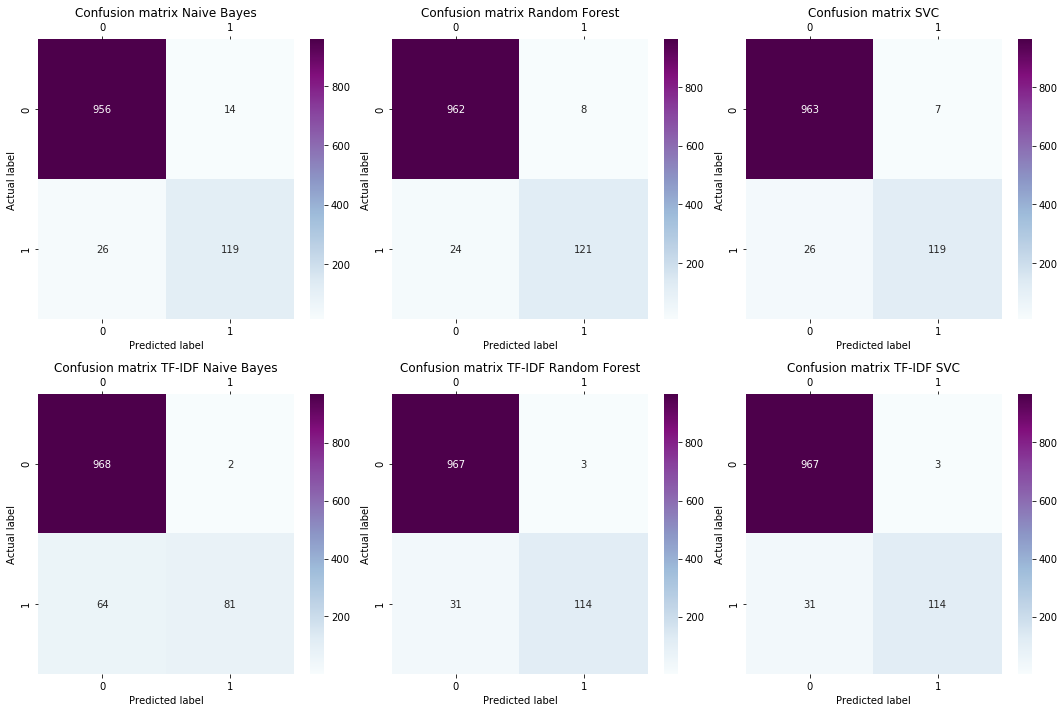

In [152]:
cmNB = confusion_matrix(datapredict['y actual count'],datapredict['NBC'])
cmFor = confusion_matrix(datapredict['y actual count'],datapredict['Forest'])
cmSvc = confusion_matrix(datapredict['y actual count'],datapredict['SVC'])
cmNBtf = confusion_matrix(datapredict['y actual TF-IDF'],datapredict['NBC TF'])
cmFortf = confusion_matrix(datapredict['y actual TF-IDF'],datapredict['Forest TF'])
cmSvctf = confusion_matrix(datapredict['y actual TF-IDF'],datapredict['SVC TF'])
class_names=[0,1] # name  of classes


# fig, ax = plt.subplots()
plt.figure(figsize=(15,10))
plt.subplot(231)
tick_marks = [0,1]
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# # create heatmap
sb.heatmap(pd.DataFrame(cmNB), annot=True, cmap="BuPu" ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Naive Bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


plt.subplot(232)
# fig, ax = plt.subplots()
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# # create heatmap
sb.heatmap(pd.DataFrame(cmFor), annot=True, cmap="BuPu" ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix Random Forest', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(233)
# fig, ax = plt.subplots()
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# # create heatmap
sb.heatmap(pd.DataFrame(cmSvc), annot=True, cmap="BuPu" ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix SVC', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')




# fig, ax = plt.subplots()
plt.subplot(234)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# # create heatmap
sb.heatmap(pd.DataFrame(cmNBtf), annot=True, cmap="BuPu" ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix TF-IDF Naive Bayes', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(235)
# fig, ax = plt.subplots(132)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# # create heatmap
sb.heatmap(pd.DataFrame(cmFortf), annot=True, cmap="BuPu" ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix TF-IDF Random Forest', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

plt.subplot(236)
# fig, ax = plt.subplots(133)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# # create heatmap
sb.heatmap(pd.DataFrame(cmSvctf), annot=True, cmap="BuPu" ,fmt='g')
# ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix TF-IDF SVC', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# dfcm= pd.DataFrame(cmNB, columns=['Prediksi 0','Prediksi 1'], index=['Actual 0','Actual 1'])
# dfcm

In [129]:
print(classification_report(datapredict['y actual count'],datapredict['NBC']))
print(classification_report(datapredict['y actual count'],datapredict['Forest']))
print(classification_report(datapredict['y actual count'],datapredict['SVC']))


              precision    recall  f1-score   support

           0       0.97      0.99      0.98       970
           1       0.89      0.82      0.86       145

    accuracy                           0.96      1115
   macro avg       0.93      0.90      0.92      1115
weighted avg       0.96      0.96      0.96      1115

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       970
           1       0.94      0.83      0.88       145

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       970
           1       0.94      0.82      0.88       145

    accuracy                           0.97      1115
   macro avg       0.96      0.91      0.93      1115
weighted avg       0.97      0.97      0.97      1115



In [153]:
print(classification_report(datapredict['y actual TF-IDF'],datapredict['NBC TF']))
print(classification_report(datapredict['y actual TF-IDF'],datapredict['Forest TF']))
print(classification_report(datapredict['y actual TF-IDF'],datapredict['SVC TF']))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       970
           1       0.98      0.56      0.71       145

    accuracy                           0.94      1115
   macro avg       0.96      0.78      0.84      1115
weighted avg       0.94      0.94      0.93      1115

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       970
           1       0.97      0.79      0.87       145

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       970
           1       0.97      0.79      0.87       145

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



### Create Joblib Model for Applications ###

In [148]:
import joblib

In [154]:
# joblib.dump(BestmodelSVC, 'modelSPAM')

['modelSPAM']